In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas pyarrow


In [ ]:
!git --version  # check if git is installed
!git config --global user.name "SuchetSanjeev"
!git config --global user.email "suchetsanjeev.patil@gmail.com"

git version 2.34.1


In [ ]:
!git remote -v

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
!git init
!git remote add origin https://github.com/SuchetSanjeev/hybrid-financial-fraud-detection.git

Reinitialized existing Git repository in /content/.git/


In [61]:
%cd /content/drive/MyDrive/Colab\ Notebooks/
!pwd
!ls

/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks
BigDataAnalytics.ipynb		      HybridFraudLSTM.ipynb
Encrypted_traffic_analysis_LLM.ipynb  NaiveBayesHybridFraudDetectionMLmodel


In [66]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/drive/MyDrive/Colab Notebooks/.git/


In [67]:
!git branch -M main


In [64]:
!git remote add origin https://github.com/SuchetSanjeev/hybrid-financial-fraud-detection.git

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [65]:
!git remote -v

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
!git add HybridFraudLSTM.ipynb
!git commit -m "Initial commit from Colab"
# !git branch -M main

fatal: pathspec 'HybridFraudLSTM.ipynb' did not match any files
On branch main

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	drive/
	hybrid-financial-fraud-detection/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git push -u origin main


error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/SuchetSanjeev/hybrid-financial-fraud-detection.git7'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load datasets
df1 = pd.read_parquet('/content/drive/MyDrive/HybridFinancialFraud/train0000.parquet')
df2 = pd.read_parquet('/content/drive/MyDrive/HybridFinancialFraud/train0001.parquet')

# Combine datasets
df = pd.concat([df1, df2], ignore_index=True)

# Read combined dataset
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

                                               input          output  \
0  {"type":"PAYMENT","amount":11801.49,"customer_...  not Fraudulent   
1  {"type":"PAYMENT","amount":10745.56,"customer_...  not Fraudulent   
2  {"type":"CASH_IN","amount":32430.23,"customer_...  not Fraudulent   
3  {"type":"PAYMENT","amount":19729.88,"customer_...  not Fraudulent   
4  {"type":"PAYMENT","amount":2663.59,"customer_s...  not Fraudulent   

                                         instruction  
0  Please find intent for this payment transactio...  
1  Please find intent for this payment transactio...  
2  Please find intent for this payment transactio...  
3  Please find intent for this payment transactio...  
4  Please find intent for this payment transactio...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385983 entries, 0 to 2385982
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   input        object
 1   output       object
 2   instruction  object


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


# Load datasets
df1 = pd.read_parquet('/content/drive/MyDrive/HybridFinancialFraud/train0000.parquet')
df2 = pd.read_parquet('/content/drive/MyDrive/HybridFinancialFraud/train0001.parquet')

# Combine datasets
df = pd.concat([df1, df2], ignore_index=True)

# Read combined dataset
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Drop instruction column since it contains redundant information
df = df.drop('instruction', axis=1)

# Convert 'output' column to binary labels
df['output'] = df['output'].map({'Fraudulent': 1, 'not Fraudulent': 0})

# Parse JSON data from 'input' column
def parse_json(data):
    try:
        return json.loads(data)
    except:
        return None

parsed_data = df['input'].apply(parse_json)
df_parsed = pd.json_normalize(parsed_data)

# Drop non-numeric columns
df_parsed = df_parsed.select_dtypes(include=[np.number])

# Merge parsed features with labels
df_final = pd.concat([df_parsed, df['output']], axis=1)

# Drop rows with missing values
df_final = df_final.dropna()

# Splitting features and target
X = df_final.drop('output', axis=1)
y = df_final['output']

# Applying SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

                                               input          output  \
0  {"type":"CASH_OUT","amount":118494.78,"custome...  not Fraudulent   
1  {"type":"PAYMENT","amount":4622.01,"customer_s...  not Fraudulent   
2  {"type":"CASH_IN","amount":320356.52,"customer...  not Fraudulent   
3  {"type":"CASH_IN","amount":190644.46,"customer...  not Fraudulent   
4  {"type":"PAYMENT","amount":20845.24,"customer_...  not Fraudulent   

                                         instruction  
0  Please find intent for this payment transactio...  
1  Please find intent for this payment transactio...  
2  Please find intent for this payment transactio...  
3  Please find intent for this payment transactio...  
4  Please find intent for this payment transactio...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385983 entries, 0 to 2385982
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   input        object
 1   output       object
 2   instruction  object


In [ ]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

29788/29788 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    475892
           1       0.86      1.00      0.92    477304

    accuracy                           0.92    953196
   macro avg       0.93      0.92      0.92    953196
weighted avg       0.93      0.92      0.92    953196



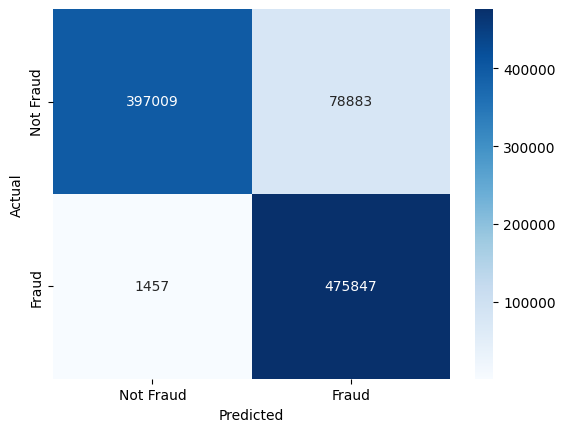

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.preprocessing import StandardScaler

# Load test datasets
df_test1 = pd.read_parquet('/content/drive/MyDrive/HybridFinancialFraud/test0000.parquet')
df_test2 = pd.read_parquet('/content/drive/MyDrive/HybridFinancialFraud/test0001.parquet')

# Combine test datasets
df_test = pd.concat([df_test1, df_test2], ignore_index=True)

# Drop 'instruction' column
df_test = df_test.drop('instruction', axis=1)

# Convert 'output' column to binary labels
df_test['output'] = df_test['output'].map({'Fraudulent': 1, 'not Fraudulent': 0})

# Parse JSON data from 'input' column
def parse_json(data):
    try:
        return json.loads(data)
    except:
        return None

parsed_data_test = df_test['input'].apply(parse_json)
df_parsed_test = pd.json_normalize(parsed_data_test)

# Drop non-numeric columns
df_parsed_test = df_parsed_test.select_dtypes(include=[np.number])

# Merge parsed features with labels
df_final_test = pd.concat([df_parsed_test, df_test['output']], axis=1)

# Drop rows with missing values
df_final_test = df_final_test.dropna()

# Splitting features and target
X_test = df_final_test.drop('output', axis=1)
y_test = df_final_test['output']

# Load the same scaler used during training
scaler = joblib.load('scaler.pkl')
X_test = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy on Test Set: {test_acc * 100:.2f}%')

# Generate predictions
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

print("First 10 Predictions:", binary_predictions[:10].flatten())


49708/49708 ━━━━━━━━━━━━━━━━━━━━ 124s 2ms/step - accuracy: 0.8336 - loss: 0.2052
Test Accuracy on Test Set: 83.36%
49708/49708 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step
First 10 Predictions: [0 0 0 0 0 0 0 0 0 0]
